# 0.0 IMPORTS

In [1]:
import inflection
import warnings
import seaborn                            as sns
import pandas                             as pd
import matplotlib.pyplot                  as plt

from matplotlib.ticker       import FuncFormatter

## 0.1 Helper Functions

In [2]:
warnings.filterwarnings('ignore')

## 0.2 Loading Data

In [3]:
dir_data = "../data/raw/microdados_censo_escolar_educacao_basica_2022/dados/"
file_data = "microdados_ed_basica_2022.csv"

# CSV
df_raw = pd.read_csv(dir_data + file_data, sep=';', encoding = "ISO-8859-1")

## 0.3 Loading Data Dictionary

In [4]:
dir_dict = "../data/raw/microdados_censo_escolar_educacao_basica_2022/Anexos/ANEXO I - Dicionаrio de Dados/"
file_dict = "dicionario_dados_educacao_basica.xlsx"

# EXCEL
df_dict = pd.read_excel(dir_dict + file_dict, skiprows=6, usecols="B:F")

In [5]:
# Filtering columns relevants by dictionary
df_private = (
    df_dict
    .loc[lambda x: (x['Nome da Variável'].notnull()) & (x['Categoria'].notnull())]
    .loc[lambda x: x['Categoria'].str.contains("Não aplicável para escolas privadas")]
    .reset_index(drop=True)
)

In [6]:
cols_remove = [i.lower() for i in list(df_private['Nome da Variável'])]

# 1.0 ETL DATA

In [7]:
df1 = df_raw.copy()

## 1.1 Filtering Data Relevants

In [8]:
# TP_DEPENDENCIA igual a 4 se refere apenas a escolas particulares
# TP_SITUACAO_FUNCIONAMENTO igual a 1 se refere apenas a escolas em funcionamento

df1 = (
    df1
    .loc[lambda x: (x['TP_DEPENDENCIA'] == 4) & (x['TP_SITUACAO_FUNCIONAMENTO'] == 1)]
    .reset_index(drop=True)
)

## 1.2 Rename Columns

In [9]:
cols_old = list(df1.columns)

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.3 Check NA

### 1.3.1 Create Data Frame with NA Percentage

In [10]:
df_isnull = pd.DataFrame(df1.isna().sum()).reset_index()
df_isnull.columns = ['attribute', 'value']
df_isnull['perc'] = round((df_isnull['value'] / df1.shape[0]) * 100, 2)

In [11]:
df_isnull[df_isnull['perc'] != 100].sort_values('perc', ascending=False).head(30)

,attribute,value,perc
264,tp_indigena_lingua,45943,99.93
69,tp_ocupacao_galpao,45867,99.76
58,co_escola_sede_vinculada,45850,99.72
59,co_ies_ofertante,45814,99.65
271,in_reserva_ppi,42291,91.98
272,in_reserva_renda,42291,91.98
273,in_reserva_publica,42291,91.98
274,in_reserva_pcd,42291,91.98
275,in_reserva_outros,42291,91.98
276,in_reserva_nenhuma,42291,91.98


### 1.3.2 Select Columns to Delete
**Column > 60% NA will be deleted**

In [12]:
cols_remove.extend(list(df_isnull[df_isnull['perc'] > 60]['attribute']))

## 1.4 Filtering Columns after Check NA

### 1.4.1 Columns deactivate

In [13]:
cols_deactivate = [
    "TP_LOCALIZACAO",
    "TP_LOCALIZACAO_DIFERENCIADA",
    "TP_SITUACAO_FUNCIONAMENTO",
    "CO_ORGAO_REGIONAL",
    "DT_ANO_LETIVO_INICIO",
    "DT_ANO_LETIVO_TERMINO",
    "IN_VINCULO_SECRETARIA_EDUCACAO",
    "IN_VINCULO_SEGURANCA_PUBLICA",
    "IN_VINCULO_SECRETARIA_SAUDE",
    "IN_VINCULO_OUTRO_ORGAO",
    "IN_PODER_PUBLICO_PARCERIA",
    "TP_PODER_PUBLICO_PARCERIA",
    "IN_CONVENIADA_PP",
    "TP_CONVENIO_PODER_PUBLICO",
    "IN_FORMA_CONT_TERMO_COLABORA",
    "IN_FORMA_CONT_TERMO_FOMENTO",
    "IN_FORMA_CONT_ACORDO_COOP",
    "IN_FORMA_CONT_PRESTACAO_SERV",
    "IN_FORMA_CONT_COOP_TEC_FIN",
    "IN_FORMA_CONT_CONSORCIO_PUB",
    "IN_TIPO_ATEND_ESCOLARIZACAO",
    "IN_TIPO_ATEND_AC",
    "IN_TIPO_ATEND_AEE",
    "IN_MANT_ESCOLA_PRIVADA_EMP",
    "IN_MANT_ESCOLA_PRIVADA_ONG",
    "IN_MANT_ESCOLA_PRIVADA_OSCIP",
    "IN_MANT_ESCOLA_PRIV_ONG_OSCIP",
    "IN_MANT_ESCOLA_PRIVADA_SIND",
    "IN_MANT_ESCOLA_PRIVADA_SIST_S",
    "IN_MANT_ESCOLA_PRIVADA_S_FINS",
    "NU_CNPJ_ESCOLA_PRIVADA",
    "NU_CNPJ_MANTENEDORA",
    "TP_REGULAMENTACAO",
    "TP_RESPONSAVEL_REGULAMENTACAO",
    "CO_ESCOLA_SEDE_VINCULADA",
    "CO_IES_OFERTANTE",
    "IN_LOCAL_FUNC_PREDIO_ESCOLAR",
    "TP_OCUPACAO_PREDIO_ESCOLAR",
    "IN_LOCAL_FUNC_SALAS_EMPRESA",
    "IN_LOCAL_FUNC_SOCIOEDUCATIVO",
    "IN_LOCAL_FUNC_UNID_PRISIONAL",
    "IN_LOCAL_FUNC_PRISIONAL_SOCIO",
    "IN_LOCAL_FUNC_TEMPLO_IGREJA",
    "IN_LOCAL_FUNC_CASA_PROFESSOR",
    "IN_LOCAL_FUNC_GALPAO",
    "TP_OCUPACAO_GALPAO",
    "IN_LOCAL_FUNC_SALAS_OUTRA_ESC",
    "IN_LOCAL_FUNC_OUTROS",
    "IN_PREDIO_COMPARTILHADO",
    "IN_AGUA_FILTRADA",
    "IN_AGUA_POTAVEL",
    "IN_AGUA_REDE_PUBLICA",
    "IN_AGUA_POCO_ARTESIANO",
    "IN_AGUA_CACIMBA",
    "IN_AGUA_FONTE_RIO",
    "IN_AGUA_INEXISTENTE",
    "IN_ENERGIA_REDE_PUBLICA",
    "IN_ENERGIA_GERADOR",
    "IN_ENERGIA_GERADOR_FOSSIL",
    "IN_ENERGIA_OUTROS",
    "IN_ENERGIA_RENOVAVEL",
    "IN_ENERGIA_INEXISTENTE",
    "IN_ESGOTO_REDE_PUBLICA",
    "IN_ESGOTO_FOSSA_SEPTICA",
    "IN_ESGOTO_FOSSA_COMUM",
    "IN_ESGOTO_FOSSA",
    "IN_ESGOTO_INEXISTENTE",
    "IN_LIXO_SERVICO_COLETA",
    "IN_LIXO_QUEIMA",
    "IN_LIXO_ENTERRA",
    "IN_LIXO_DESTINO_FINAL_PUBLICO",
    "IN_LIXO_DESCARTA_OUTRA_AREA",
    "IN_LIXO_JOGA_OUTRA_AREA",
    "IN_LIXO_OUTROS",
    "IN_LIXO_RECICLA",
    "IN_TRATAMENTO_LIXO_SEPARACAO",
    "IN_TRATAMENTO_LIXO_REUTILIZA",
    "IN_TRATAMENTO_LIXO_RECICLAGEM",
    "IN_TRATAMENTO_LIXO_INEXISTENTE",
    "IN_ALMOXARIFADO",
    "IN_AREA_VERDE",
    "IN_AUDITORIO",
    "IN_BANHEIRO_FORA_PREDIO",
    "IN_BANHEIRO_DENTRO_PREDIO",
    "IN_BANHEIRO",
    "IN_BANHEIRO_EI",
    "IN_BANHEIRO_PNE",
    "IN_BANHEIRO_FUNCIONARIOS",
    "IN_BANHEIRO_CHUVEIRO",
    "IN_BERCARIO",
    "IN_BIBLIOTECA",
    "IN_BIBLIOTECA_SALA_LEITURA",
    "IN_COZINHA",
    "IN_DESPENSA",
    "IN_DORMITORIO_ALUNO",
    "IN_DORMITORIO_PROFESSOR",
    "IN_LABORATORIO_CIENCIAS",
    "IN_LABORATORIO_INFORMATICA",
    "IN_LABORATORIO_EDUC_PROF",
    "IN_PATIO_COBERTO",
    "IN_PATIO_DESCOBERTO",
    "IN_PARQUE_INFANTIL",
    "IN_PISCINA",
    "IN_QUADRA_ESPORTES",
    "IN_QUADRA_ESPORTES_COBERTA",
    "IN_QUADRA_ESPORTES_DESCOBERTA",
    "IN_REFEITORIO",
    "IN_SALA_ATELIE_ARTES",
    "IN_SALA_MUSICA_CORAL",
    "IN_SALA_ESTUDIO_DANCA",
    "IN_SALA_MULTIUSO",
    "IN_SALA_OFICINAS_EDUC_PROF",
    "IN_SALA_DIRETORIA",
    "IN_SALA_LEITURA",
    "IN_SALA_PROFESSOR",
    "IN_SALA_REPOUSO_ALUNO",
    "IN_SECRETARIA",
    "IN_SALA_ATENDIMENTO_ESPECIAL",
    "IN_TERREIRAO",
    "IN_VIVEIRO",
    "IN_DEPENDENCIAS_PNE",
    "IN_LAVANDERIA",
    "IN_DEPENDENCIAS_OUTRAS",
    "IN_ACESSIBILIDADE_CORRIMAO",
    "IN_ACESSIBILIDADE_ELEVADOR",
    "IN_ACESSIBILIDADE_PISOS_TATEIS",
    "IN_ACESSIBILIDADE_VAO_LIVRE",
    "IN_ACESSIBILIDADE_RAMPAS",
    "IN_ACESSIBILIDADE_SINAL_SONORO",
    "IN_ACESSIBILIDADE_SINAL_TATIL",
    "IN_ACESSIBILIDADE_SINAL_VISUAL",
    "IN_ACESSIBILIDADE_INEXISTENTE",
    "QT_SALAS_UTILIZADAS_DENTRO",
    "QT_SALAS_UTILIZADAS_FORA",
    "QT_SALAS_UTILIZA_CLIMATIZADAS",
    "QT_SALAS_UTILIZADAS_ACESSIVEIS",
    "IN_EQUIP_PARABOLICA",
    "IN_COMPUTADOR",
    "IN_EQUIP_COPIADORA",
    "IN_EQUIP_IMPRESSORA",
    "IN_EQUIP_IMPRESSORA_MULT",
    "IN_EQUIP_SCANNER",
    "IN_EQUIP_NENHUM",
    "IN_EQUIP_DVD",
    "QT_EQUIP_DVD",
    "IN_EQUIP_SOM",
    "QT_EQUIP_SOM",
    "IN_EQUIP_TV",
    "QT_EQUIP_TV",
    "IN_EQUIP_LOUSA_DIGITAL",
    "QT_EQUIP_LOUSA_DIGITAL",
    "IN_EQUIP_MULTIMIDIA",
    "QT_EQUIP_MULTIMIDIA",
    "IN_EQUIP_VIDEOCASSETE",
    "IN_EQUIP_RETROPROJETOR",
    "IN_EQUIP_FAX",
    "IN_EQUIP_FOTO",
    "QT_EQUIP_VIDEOCASSETE",
    "QT_EQUIP_PARABOLICA",
    "QT_EQUIP_COPIADORA",
    "QT_EQUIP_RETROPROJETOR",
    "QT_EQUIP_IMPRESSORA",
    "QT_EQUIP_IMPRESSORA_MULT",
    "QT_EQUIP_FAX",
    "QT_EQUIP_FOTO",
    "QT_COMP_ALUNO",
    "IN_DESKTOP_ALUNO",
    "QT_DESKTOP_ALUNO",
    "IN_COMP_PORTATIL_ALUNO",
    "QT_COMP_PORTATIL_ALUNO",
    "IN_TABLET_ALUNO",
    "QT_TABLET_ALUNO",
    "QT_COMPUTADOR",
    "QT_COMP_ADMINISTRATIVO",
    "IN_INTERNET",
    "IN_INTERNET_ALUNOS",
    "IN_INTERNET_ADMINISTRATIVO",
    "IN_INTERNET_APRENDIZAGEM",
    "IN_INTERNET_COMUNIDADE",
    "IN_ACESSO_INTERNET_COMPUTADOR",
    "IN_ACES_INTERNET_DISP_PESSOAIS",
    "TP_REDE_LOCAL",
    "IN_BANDA_LARGA",
    "QT_FUNCIONARIOS",
    "IN_PROF_ADMINISTRATIVOS",
    "QT_PROF_ADMINISTRATIVOS",
    "IN_PROF_SERVICOS_GERAIS",
    "QT_PROF_SERVICOS_GERAIS",
    "IN_PROF_BIBLIOTECARIO",
    "QT_PROF_BIBLIOTECARIO",
    "IN_PROF_SAUDE",
    "QT_PROF_SAUDE",
    "IN_PROF_COORDENADOR",
    "QT_PROF_COORDENADOR",
    "IN_PROF_FONAUDIOLOGO",
    "QT_PROF_FONAUDIOLOGO",
    "IN_PROF_NUTRICIONISTA",
    "QT_PROF_NUTRICIONISTA",
    "IN_PROF_PSICOLOGO",
    "QT_PROF_PSICOLOGO",
    "IN_PROF_ALIMENTACAO",
    "QT_PROF_ALIMENTACAO",
    "IN_PROF_PEDAGOGIA",
    "QT_PROF_PEDAGOGIA",
    "IN_PROF_SECRETARIO",
    "QT_PROF_SECRETARIO",
    "IN_PROF_SEGURANCA",
    "QT_PROF_SEGURANCA",
    "IN_PROF_MONITORES",
    "QT_PROF_MONITORES",
    "IN_PROF_GESTAO",
    "QT_PROF_GESTAO",
    "IN_PROF_ASSIST_SOCIAL",
    "QT_PROF_ASSIST_SOCIAL",
    "IN_ALIMENTACAO",
    "IN_SERIE_ANO",
    "IN_PERIODOS_SEMESTRAIS",
    "IN_FUNDAMENTAL_CICLOS",
    "IN_GRUPOS_NAO_SERIADOS",
    "IN_MODULOS",
    "IN_FORMACAO_ALTERNANCIA",
    "IN_MATERIAL_PED_MULTIMIDIA",
    "IN_MATERIAL_PED_INFANTIL",
    "IN_MATERIAL_PED_CIENTIFICO",
    "IN_MATERIAL_PED_DIFUSAO",
    "IN_MATERIAL_PED_MUSICAL",
    "IN_MATERIAL_PED_JOGOS",
    "IN_MATERIAL_PED_ARTISTICAS",
    "IN_MATERIAL_PED_PROFISSIONAL",
    "IN_MATERIAL_PED_DESPORTIVA",
    "IN_MATERIAL_PED_INDIGENA",
    "IN_MATERIAL_PED_ETNICO",
    "IN_MATERIAL_PED_CAMPO",
    "IN_MATERIAL_PED_NENHUM",
    "IN_MATERIAL_ESP_QUILOMBOLA",
    "IN_MATERIAL_ESP_INDIGENA",
    "IN_MATERIAL_ESP_NAO_UTILIZA",
    "IN_EDUCACAO_INDIGENA",
    "TP_INDIGENA_LINGUA",
    "CO_LINGUA_INDIGENA_1",
    "CO_LINGUA_INDIGENA_2",
    "CO_LINGUA_INDIGENA_3",
    "IN_BRASIL_ALFABETIZADO",
    "IN_FINAL_SEMANA",
    "IN_EXAME_SELECAO",
    "IN_RESERVA_PPI",
    "IN_RESERVA_RENDA",
    "IN_RESERVA_PUBLICA",
    "IN_RESERVA_PCD",
    "IN_RESERVA_OUTROS",
    "IN_RESERVA_NENHUMA",
    "IN_REDES_SOCIAIS",
    "IN_ESPACO_ATIVIDADE",
    "IN_ESPACO_EQUIPAMENTO",
    "IN_ORGAO_ASS_PAIS",
    "IN_ORGAO_ASS_PAIS_MESTRES",
    "IN_ORGAO_CONSELHO_ESCOLAR",
    "IN_ORGAO_GREMIO_ESTUDANTIL",
    "IN_ORGAO_OUTROS",
    "IN_ORGAO_NENHUM",
    "TP_PROPOSTA_PEDAGOGICA",
    "TP_AEE",
    "TP_ATIVIDADE_COMPLEMENTAR",
    "IN_ESCOLARIZACAO",
    "IN_REGULAR",
    "IN_DIURNO",
    "IN_NOTURNO",
    "IN_EAD",
    "IN_BAS",
    "IN_INF",
    "IN_INF_CRE",
    "IN_INF_PRE",
    "IN_FUND",
    "IN_FUND_AI",
    "IN_FUND_AF",
    "IN_MED",
    "IN_PROF",
    "IN_PROF_TEC",
    "IN_EJA",
    "IN_EJA_FUND",
    "IN_EJA_MED",
    "IN_ESP",
    "IN_ESP_CC",
    "IN_ESP_CE",
    "QT_MAT_BAS_ND",
    "QT_MAT_BAS_BRANCA",
    "QT_MAT_BAS_PRETA",
    "QT_MAT_BAS_PARDA",
    "QT_MAT_BAS_AMARELA",
    "QT_MAT_BAS_INDIGENA"
]

In [14]:
cols_deactivate = [i.lower() for i in cols_deactivate]

### 1.4.2 Remove columns deactivate

In [15]:
cols_remove.extend(cols_deactivate)

In [16]:
df1 = df1.drop(cols_remove, axis=1)

## 1.5 Data Dimensions

In [17]:
print( 'From {} number of rows in Raw Data to {} rows filtered'.format(df_raw.shape[0], df1.shape[0]) )
print( 'From {} number of columns in Raw Data to {} columns filtered'.format(df_raw.shape[1], df1.shape[1]) )

From 224649 number of rows in Raw Data to 45977 rows filtered
From 385 number of columns in Raw Data to 93 columns filtered


# 2.0 EDA

In [18]:
df2 = df1.copy()

## 2.1 Matrículas por idade em cada região do Brasil

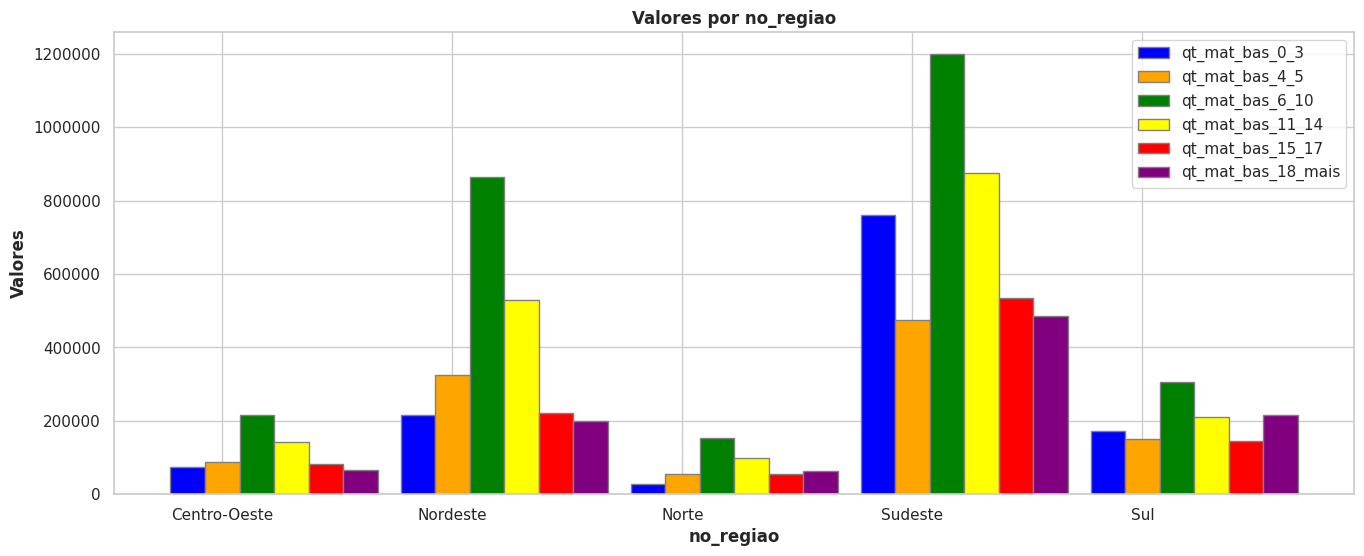

In [19]:
# Agrupando um novo dataframe para análise
hip_1 = df2[['no_regiao', 'qt_mat_bas_0_3', 'qt_mat_bas_4_5', 'qt_mat_bas_6_10', 'qt_mat_bas_11_14', 'qt_mat_bas_15_17', 'qt_mat_bas_18_mais']].groupby('no_regiao').sum().reset_index()

# Configuração do estilo Seaborn
sns.set(style="whitegrid")

# Plotando o gráfico
plt.figure(figsize=(16, 6))
bar_width = 0.15

# Ajuste das posições das barras para evitar sobreposições
r1 = range(len(hip_1['no_regiao']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Criando as barras
plt.bar(r1, hip_1['qt_mat_bas_0_3'], color='blue', width=bar_width, edgecolor='grey', label='qt_mat_bas_0_3')
plt.bar(r2, hip_1['qt_mat_bas_4_5'], color='orange', width=bar_width, edgecolor='grey', label='qt_mat_bas_4_5')
plt.bar(r3, hip_1['qt_mat_bas_6_10'], color='green', width=bar_width, edgecolor='grey', label='qt_mat_bas_6_10')
plt.bar(r4, hip_1['qt_mat_bas_11_14'], color='yellow', width=bar_width, edgecolor='grey', label='qt_mat_bas_11_14')
plt.bar(r5, hip_1['qt_mat_bas_15_17'], color='red', width=bar_width, edgecolor='grey', label='qt_mat_bas_15_17')
plt.bar(r6, hip_1['qt_mat_bas_18_mais'], color='purple', width=bar_width, edgecolor='grey', label='qt_mat_bas_18_mais')

# Adicionando rótulos e título
plt.xlabel('no_regiao', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(hip_1['no_regiao']))], hip_1['no_regiao'])
plt.ylabel('Valores', fontweight='bold')
plt.title('Valores por no_regiao', fontweight='bold')

# Configurando a notação científica no eixo y
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# Adicionando a legenda
plt.legend()

# Exibindo o gráfico
plt.show()

## 2.2 Matrículas por idade em cada UF do Brasil

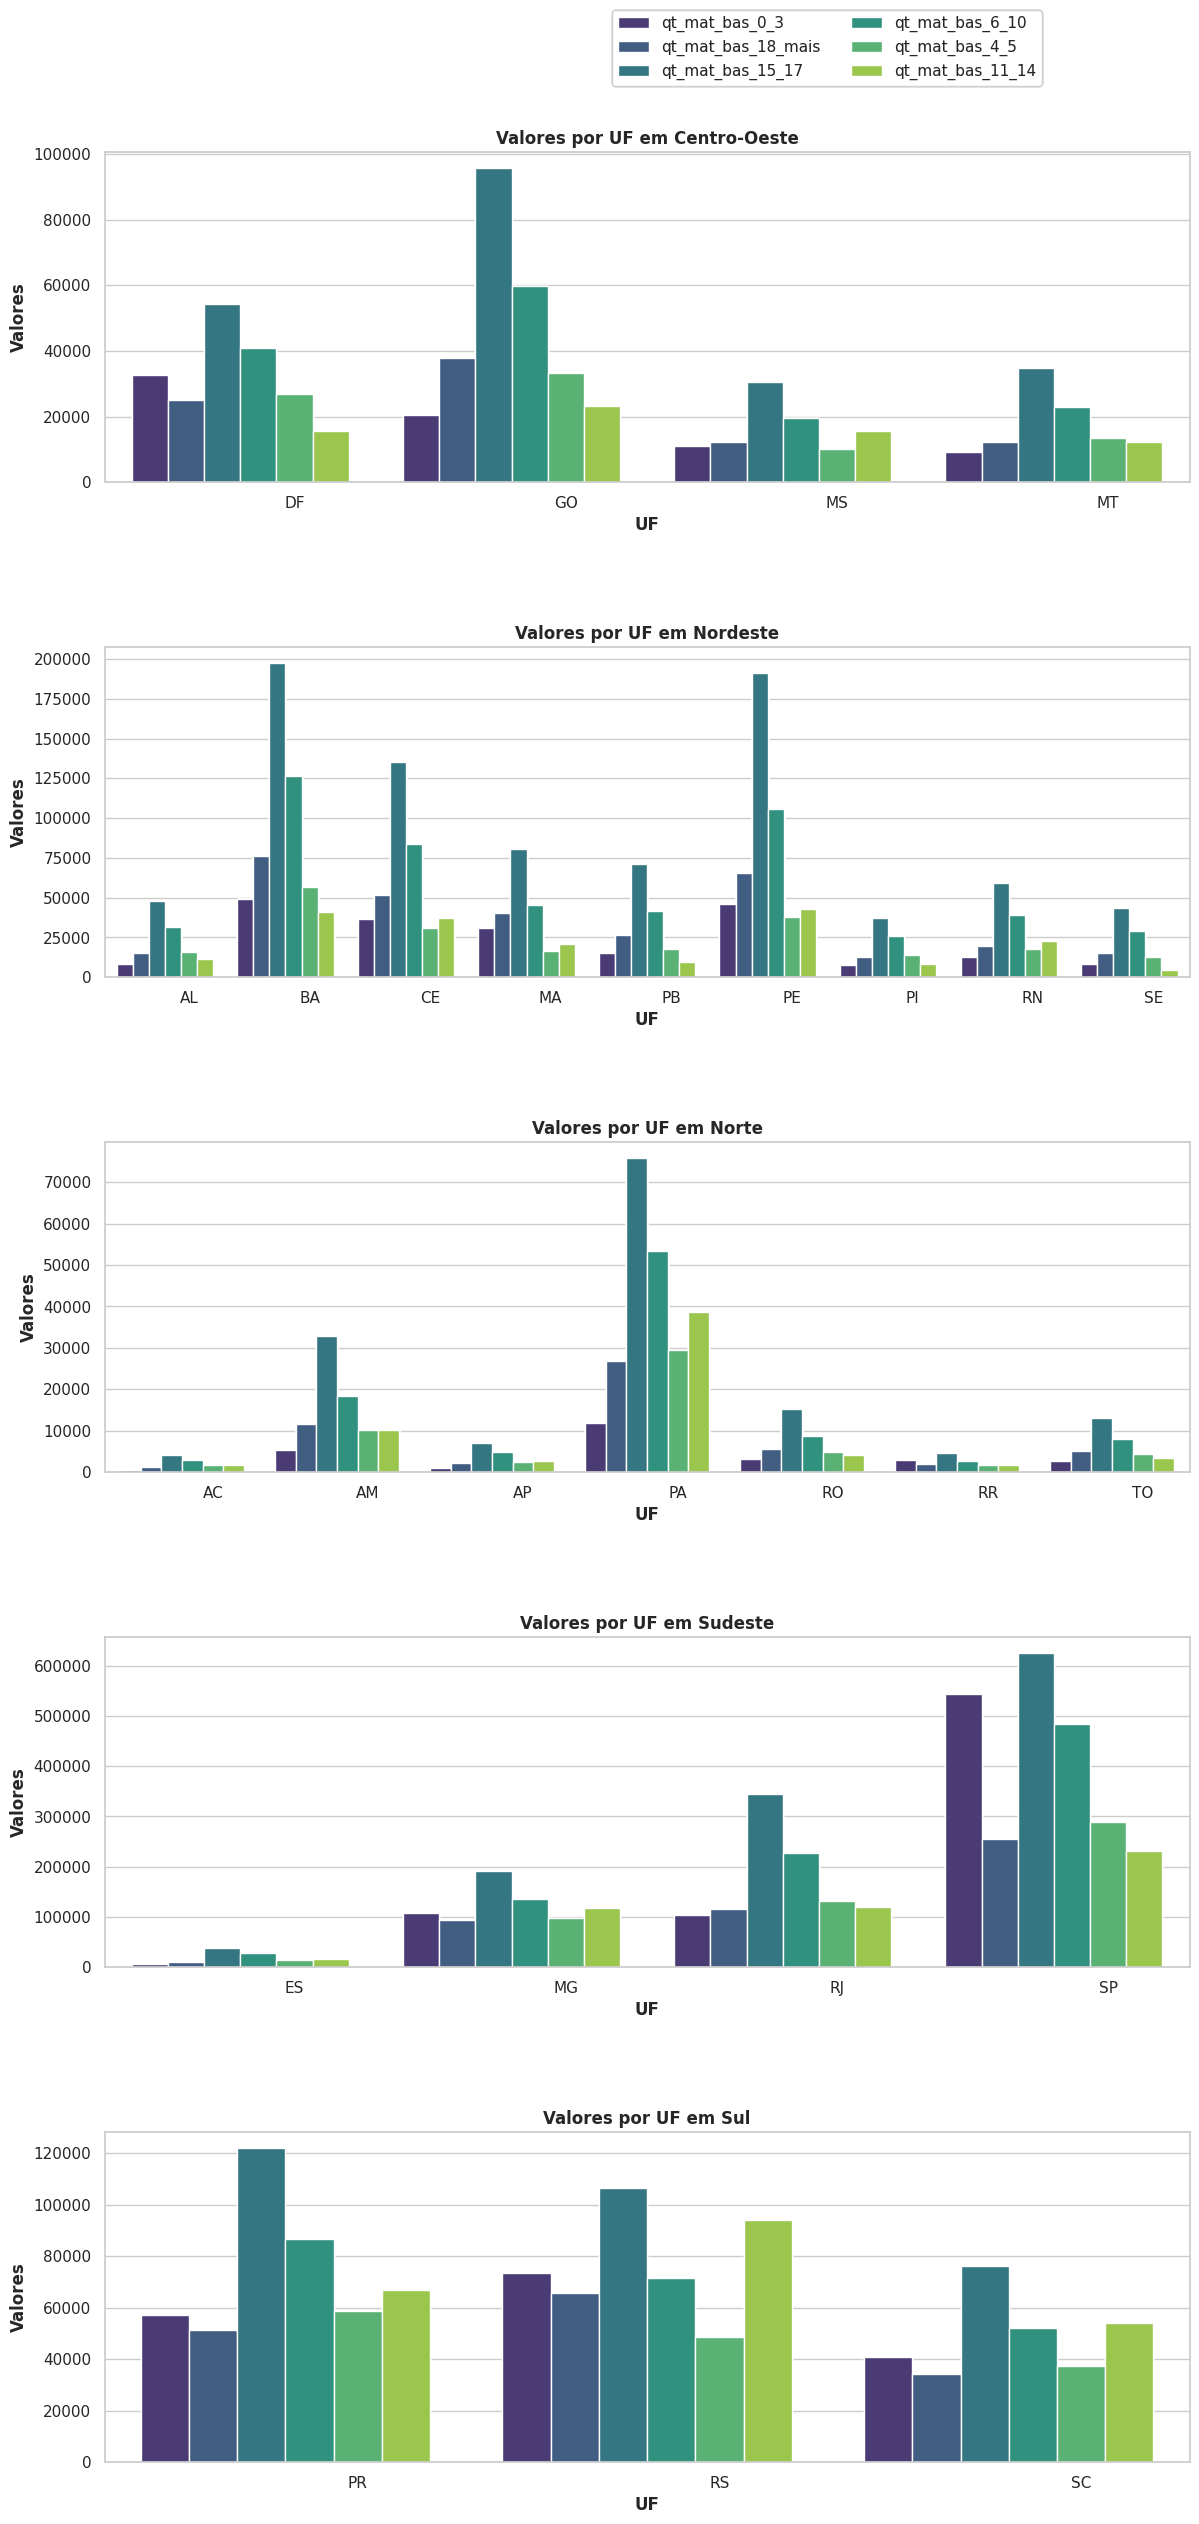

In [20]:
# Agrupando um novo dataframe para análise
hip_2 = df2[[
    'no_regiao', 'sg_uf', 'qt_mat_bas_0_3', 'qt_mat_bas_4_5', 'qt_mat_bas_6_10', 'qt_mat_bas_11_14', 'qt_mat_bas_15_17', 'qt_mat_bas_18_mais'
]].groupby(['no_regiao', 'sg_uf']).sum().reset_index()
hip_2_melt = pd.melt(hip_2, id_vars=['no_regiao', 'sg_uf'], var_name='Variavel', value_name='Valor')

# Configuração do estilo Seaborn
sns.set(style="whitegrid")

# Obter regiões únicas
regions = hip_2['no_regiao'].unique()

# Criar subplots para cada região
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(14, 6 * len(regions)))

# Iterar sobre as regiões e plotar gráficos
for i, region in enumerate(regions):
    region_data = hip_2_melt[hip_2_melt['no_regiao'] == region]
    
    # Ajustar o espaço entre os subplots
    plt.subplots_adjust(hspace=0.5)
    
    # Ajustar as posições das barras para evitar sobreposições
    bar_width = 0.2
    r_positions = [r + bar_width * j for j, r in enumerate(range(len(region_data['sg_uf'].unique())))]
    
    # Plotar as barras em cada subplot
    for k, uf in enumerate(region_data['sg_uf'].unique()):
        uf_data = region_data[region_data['sg_uf'] == uf]
        r = [x + bar_width * k for x in r_positions]
        sns.barplot(x='sg_uf', y='Valor', hue='Variavel', data=region_data, palette="viridis", ax=axes[i])
    
    # Adicionar rótulos e título a cada subplot
    axes[i].set_xlabel('UF', fontweight='bold')
    axes[i].set_xticks([r + bar_width for r in range(len(region_data['sg_uf'].unique()))])
    axes[i].set_xticklabels(region_data['sg_uf'].unique())
    axes[i].set_ylabel('Valores', fontweight='bold')
    axes[i].set_title(f'Valores por UF em {region}', fontweight='bold')
    axes[i].get_legend().remove()

    # add legend
    handles, labels = axes[i].get_legend_handles_labels()
    fig.legend(handles, set(labels), loc='upper right', ncol=2, bbox_to_anchor=(0.8, 0.93))

# Exibir os subplots
plt.show()

## 2.3 As 10 cidades com maiores quantidades de matrículas para os ensinos infantil, fundamental e médio

In [21]:
hip_3 = df2[[
    'sg_uf', 'no_municipio', 'qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'
]].groupby(['sg_uf', 'no_municipio']).sum().reset_index()

# 10 maiores cidades por UF em cada faixa de idade de matriculas
top_10 = hip_3.sort_values(['qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'], ascending=False).head(10)[['sg_uf', 'no_municipio', 'qt_mat_bas', 'qt_mat_fund', 'qt_mat_med']].reset_index()
top_10

,index,sg_uf,no_municipio,qt_mat_bas,qt_mat_fund,qt_mat_med
0,3298,SP,São Paulo,959522.0,353961.0,80885.0
1,2335,RJ,Rio de Janeiro,458396.0,233191.0,61683.0
2,565,DF,Brasília,195686.0,94264.0,26453.0
3,464,CE,Fortaleza,191670.0,110233.0,21226.0
4,918,MG,Belo Horizonte,178466.0,75760.0,21967.0
5,336,BA,Salvador,177838.0,89168.0,19687.0
6,2016,PR,Curitiba,133790.0,56741.0,18756.0
7,2633,RS,Porto Alegre,133290.0,45163.0,12602.0
8,1794,PE,Recife,126402.0,71008.0,13417.0
9,671,GO,Goiânia,103042.0,60589.0,15155.0


In [22]:
top_10_cidades = top_10['no_municipio'].unique()

## 2.4 Dessas 10 cidades, quais são os bairros com as maiores quantidades de matrículas?

In [23]:
hip_4 = df2[df2['no_municipio']=='São Paulo'].reset_index()

hip_4 = df2[[
    'sg_uf', 'no_municipio','no_bairro', 'qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'
]].groupby(['no_municipio','sg_uf','no_bairro']).sum().reset_index()

In [24]:
hip_4_final = pd.DataFrame()

for i in top_10_cidades:
    aux = hip_4[hip_4['no_municipio']== i].groupby('no_bairro').sum().reset_index()
    hip_4_final = pd.concat([aux.sort_values(['qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'], ascending=False).head(10).reset_index(drop=True), hip_4_final], axis=0)

hip_4_final

,no_bairro,no_municipio,sg_uf,qt_mat_bas,qt_mat_fund,qt_mat_med
0,SETOR BUENO,Goiânia,GO,12679.0,6668.0,3781.0
1,SETOR CENTRAL,Goiânia,GO,7206.0,2533.0,1229.0
2,SETOR MARISTA,Goiânia,GO,5390.0,2961.0,1393.0
3,JARDIM AMERICA,Goiânia,GO,4432.0,2952.0,542.0
4,JARDIM PLANALTO,Goiânia,GO,3196.0,2250.0,726.0
...,...,...,...,...,...,...
5,SAO MIGUEL PAULISTA,São Paulo,SP,7607.0,2607.0,694.0
6,VILA GOMES CARDIM,São Paulo,SP,7478.0,4645.0,1639.0
7,TATUAPE,São Paulo,SP,7333.0,4278.0,1140.0
8,SANTA CECILIA,São Paulo,SP,6886.0,850.0,183.0


In [25]:
# Agrupando um novo dataframe para análise
hip_4_final_melt = pd.melt(hip_4_final, id_vars=['no_bairro', 'no_municipio', 'sg_uf'], var_name='Variavel', value_name='Valor')
hip_4_final_melt

,no_bairro,no_municipio,sg_uf,Variavel,Valor
0,SETOR BUENO,Goiânia,GO,qt_mat_bas,12679.0
1,SETOR CENTRAL,Goiânia,GO,qt_mat_bas,7206.0
2,SETOR MARISTA,Goiânia,GO,qt_mat_bas,5390.0
3,JARDIM AMERICA,Goiânia,GO,qt_mat_bas,4432.0
4,JARDIM PLANALTO,Goiânia,GO,qt_mat_bas,3196.0
...,...,...,...,...,...
295,SAO MIGUEL PAULISTA,São Paulo,SP,qt_mat_med,694.0
296,VILA GOMES CARDIM,São Paulo,SP,qt_mat_med,1639.0
297,TATUAPE,São Paulo,SP,qt_mat_med,1140.0
298,SANTA CECILIA,São Paulo,SP,qt_mat_med,183.0


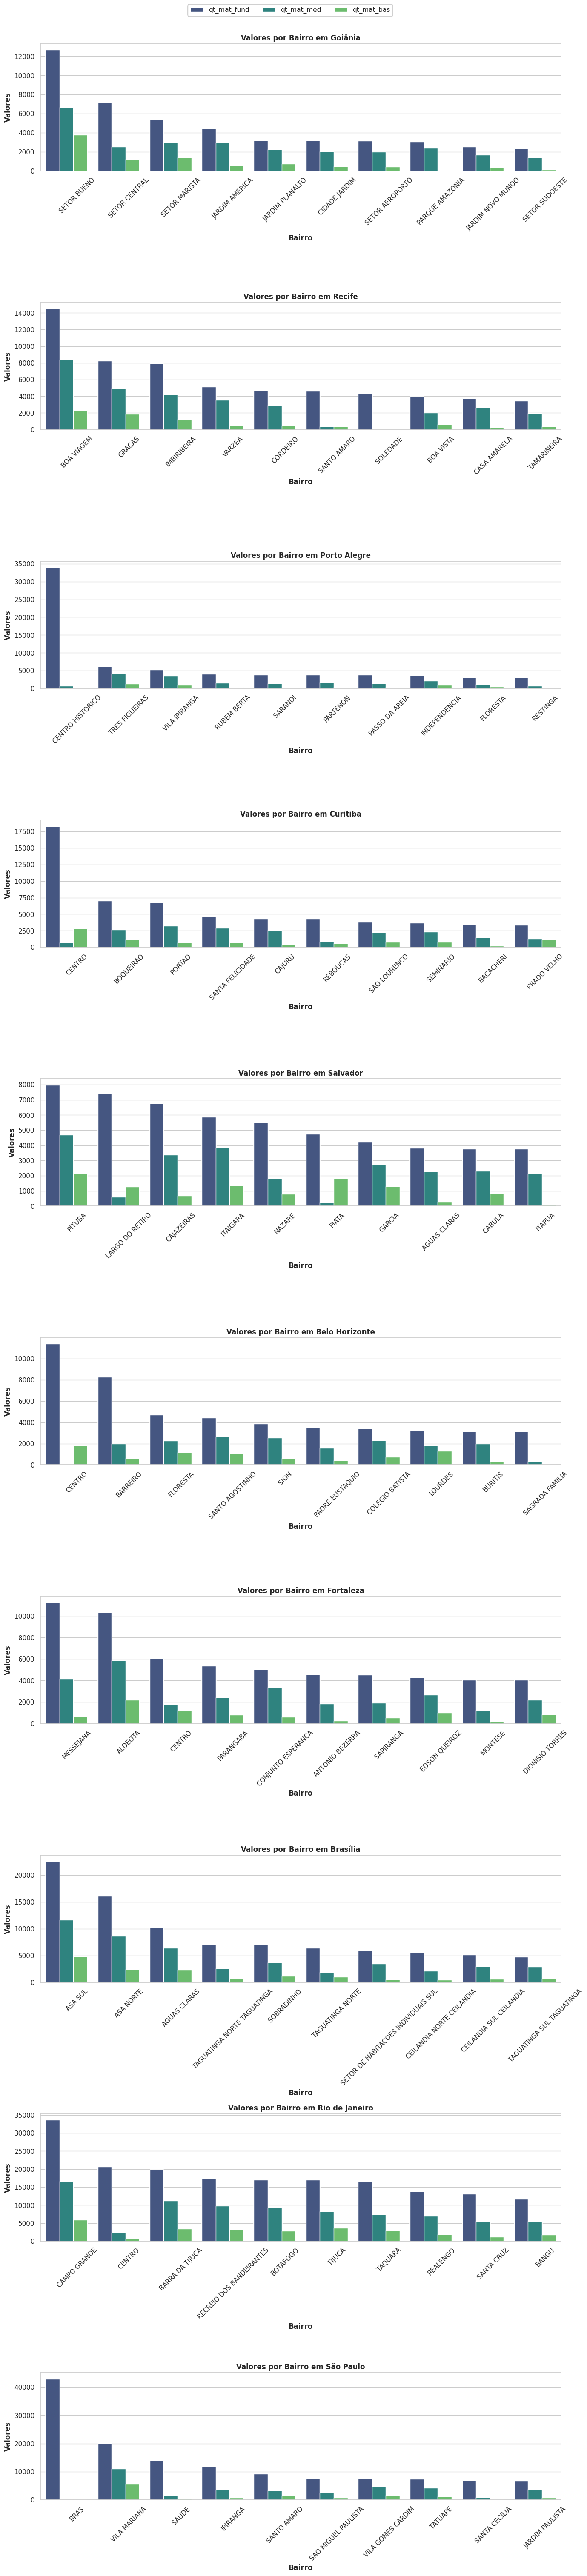

In [26]:
# Agrupando um novo dataframe para análise
hip_4_final_melt = pd.melt(hip_4_final, id_vars=['no_bairro', 'no_municipio', 'sg_uf'], var_name='Variavel', value_name='Valor')

# Configuração do estilo Seaborn
sns.set(style="whitegrid")

# Obter regiões únicas
regions = hip_4_final['no_municipio'].unique()

# Criar subplots para cada região
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(14, 6 * len(regions)))

# Iterar sobre as regiões e plotar gráficos
for i, region in enumerate(regions):
    region_data = hip_4_final_melt[hip_4_final_melt['no_municipio'] == region]
    
    # Ajustar o espaço entre os subplots
    plt.subplots_adjust(hspace=0.5)
    
    # Ajustar as posições das barras para evitar sobreposições
    bar_width = 0.2
    r_positions = [r + bar_width * j for j, r in enumerate(range(len(region_data['no_bairro'].unique())))]
    
    # Plotar as barras em cada subplot
    for k, uf in enumerate(region_data['no_bairro'].unique()):
        uf_data = region_data[region_data['no_bairro'] == uf]
        r = [x + bar_width * k for x in r_positions]
        sns.barplot(x='no_bairro', y='Valor', hue='Variavel', data=region_data, palette="viridis", ax=axes[i])
    
    # Adicionar rótulos e título a cada subplot
    axes[i].set_xlabel('Bairro', fontweight='bold')
    axes[i].set_xticks([r + bar_width for r in range(len(region_data['no_bairro'].unique()))])
    axes[i].set_xticklabels(region_data['no_bairro'].unique(), rotation=45)
    axes[i].set_ylabel('Valores', fontweight='bold')
    axes[i].set_title(f'Valores por Bairro em {region}', fontweight='bold')
    axes[i].get_legend().remove()

    # add legend
    handles, labels = axes[i].get_legend_handles_labels()
    fig.legend(handles, set(labels), loc='upper right', ncol=3, bbox_to_anchor=(0.67, 1.01))

plt.tight_layout()

# Exibir os subplots
plt.show()

**Próximos passos -> Integrar com API IBGE**
https://servicodados.ibge.gov.br/api/docs/malhas?versao=3#api-Malhas-microrregioesIdGet

## 2.5 Dentre esses bairros, quais são as principais escolas com mais matrículas por ensinos básico, fundamental e médio?

In [27]:
list_bairros = list(hip_4_final['no_bairro'].unique())
list_cidade = list(hip_4_final['no_municipio'].unique())
list_uf = list(hip_4_final['sg_uf'].unique())

hip_5 = (
    df2
    .loc[df2['no_bairro'].isin(list_bairros)]
    .loc[df2['no_municipio'].isin(list_cidade)]
    .loc[df2['sg_uf'].isin(list_uf)]
)

In [28]:
hip_5_final = hip_5[['co_entidade', 'no_entidade', 'no_bairro', 'no_municipio', 'sg_uf', 'qt_mat_bas', 'qt_mat_fund', 'qt_mat_med']].groupby(['no_entidade', 'no_bairro', 'no_municipio', 'sg_uf']).sum().reset_index()
top_escolas = []

for bairro in hip_5_final['no_bairro'].unique():

    qt_mat_bas = (
        hip_5_final
        .loc[lambda x: x['no_bairro'] == bairro]
        .sort_values('qt_mat_bas', ascending=False).head(10)
    )

    qt_mat_fund = (
        hip_5_final
        .loc[lambda x: x['no_bairro'] == bairro]
        .sort_values('qt_mat_fund', ascending=False).head(10)
    )

    qt_mat_med = (
        hip_5_final
        .loc[lambda x: x['no_bairro'] == bairro]
        .sort_values('qt_mat_med', ascending=False).head(10)
    )

    top_escolas_bairro = list(
        set(qt_mat_bas['co_entidade'].unique()) & 
        set(qt_mat_fund['co_entidade'].unique()) & 
        set(qt_mat_med['co_entidade'].unique())
    )
    
    top_escolas.extend(top_escolas_bairro)

# 3.0 Preparação da lista de escolas para prospecção

In [29]:
df3 = (
    df2
    .loc[df2['co_entidade'].isin(top_escolas)]
    .reset_index(drop=True)
)

In [30]:
df_final = df3[['no_entidade', 'ds_endereco', 'nu_endereco', 'no_bairro', 'co_cep', 'sg_uf', 'no_municipio', 'nu_ddd', 'nu_telefone']]
df_final['co_cep'] = df_final['co_cep'].astype(int)

In [31]:
df_final.head()

,no_entidade,ds_endereco,nu_endereco,no_bairro,co_cep,sg_uf,no_municipio,nu_ddd,nu_telefone
0,BATISTA SANTOS DUMONT COL,RUA DESEMBARGADOR LEITE ALBUQUERQUE,1056,ALDEOTA,60150150,CE,Fortaleza,85,40082300
1,SERAFICO NOSSA SENHORA DO BRASIL COLEGIO,AVENIDA FREI CIRILO,4454-A,MESSEJANA,60840285,CE,Fortaleza,85,32742112
2,NOSSA SENHORA DO CARMO COLEGIO,RUA ELVIRA PINHO,400,MONTESE,60421000,CE,Fortaleza,85,32250601
3,CECILIA COLEGIO SANTA,AVENIDA SENADOR VIRGILIO TAVORA,2000,ALDEOTA,60170251,CE,Fortaleza,85,30642377
4,COLEGIO CHRISTUS BARAO DE STUDART,RUA JOAO CARVALHO,630,ALDEOTA,60140140,CE,Fortaleza,85,32661800


# 4.0 Transformação para CSV

In [32]:
df_final.to_csv('../leads_top10_cidades.csv', index=False)